## Facies classification using XGBoost and engineered features


#### Contest entry by: <a href="https://github.com/mycarta">Matteo Niccoli</a>,  <a href="https://github.com/dahlmb">Mark Dahl</a>, with a contribution by Daniel Kittridge.

####  [Original contest notebook](https://github.com/seg/2016-ml-contest/blob/master/Facies_classification.ipynb) by Brendon Hall, [Enthought](https://www.enthought.com/)



<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The code and ideas in this notebook,</span> by <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Matteo Niccoli and Mark Dahl, </span> are licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

### Load the training dataset with selected set of top 45 engineered features

- We first created a large set of features from derivatives, moments, and GLCMs. The workflow is described in [this notebook]() (A huge thank you to Daniel Kittridge for his critically needed Pandas magic and useful suggestions). 
- We then selected the best performing 45 features using a Sequential (Forward) Feature Selector from Sebastian Raschka's [mlxtend](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/) library. Details in [this notebook]().


In [57]:
%matplotlib inline

import numpy as np
import pandas as pd

import scipy as sp
from scipy.signal import medfilt

from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import LeaveOneGroupOut

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from __future__ import division
mpl.rcParams['figure.figsize']=(20.0,10.0)
inline_rc = dict(mpl.rcParams)
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Load data

In [58]:
filename = 'train_SFS_top45_engfeat.csv'
train_data = pd.read_csv(filename)
train_data.describe()

,Depth,Facies,PE_GLCM_correlation_wsize=ave,DeltaPHI,PHIND,NM_M,RELPOS,GR_d1,ILD_log10_d1,DeltaPHI_d1,...,GR_skew_wsize=5,DeltaPHI_skew_wsize=9,PHIND_mean_wsize=3,PHIND_mean_wsize=ave,GR_mean_wsize=3,PE_GLCM_dissimilarity_wsize=ave,PE_GLCM_correlation_asym_wsize=9,PE_mean_wsize=65,PE_mean_wsize=129,PE_std_wsize=33
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,...,4149.000000,4149.000000,4.149000e+03,4149.000000,4.149000e+03,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000
mean,2906.867438,4.503254,0.669151,4.402484,13.201066,1.518438,0.521852,-0.000250,0.001440,0.000091,...,0.064016,0.044582,-5.252433e-14,-0.005024,2.932937e-14,2.906766,0.719862,0.007491,0.015386,0.584426
std,133.300164,2.474324,0.207747,5.274947,7.132846,0.499720,0.286644,0.322450,0.185401,0.379750,...,0.633118,0.682239,9.483332e-01,0.573990,9.615825e-01,2.365441,0.288003,0.575868,0.507093,0.448961
min,2573.500000,1.000000,0.080903,-21.832000,0.550000,1.000000,0.000000,-4.054936,-1.228861,-3.242129,...,-1.491707,-2.463226,-1.592039e+00,-1.121189,-1.774598e+00,0.000000,-0.585463,-1.301974,-1.090288,0.000000
25%,2821.500000,2.000000,0.531397,1.600000,8.500000,1.000000,0.277000,-0.094888,-0.079154,-0.145611,...,-0.382517,-0.368445,-6.488701e-01,-0.392760,-6.317280e-01,1.059152,0.563576,-0.294259,-0.247351,0.202617
50%,2932.500000,4.000000,0.639246,4.300000,12.020000,2.000000,0.528000,0.009984,-0.001979,0.000000,...,0.059526,0.062414,-1.499441e-01,-0.078404,3.564997e-03,2.643973,0.812063,0.000000,0.000000,0.580953
75%,3007.000000,6.000000,0.744366,7.500000,16.050000,2.000000,0.769000,0.103486,0.079154,0.151679,...,0.515196,0.464019,4.083389e-01,0.289299,4.655733e-01,4.343750,0.952660,0.219326,0.201666,0.923657
max,3138.000000,9.000000,1.000000,19.312000,84.400000,2.000000,1.000000,3.835455,1.980821,2.569056,...,1.493900,2.327561,9.260946e+00,3.802650,8.791173e+00,12.801339,1.000000,2.193903,2.042554,1.788092


In [59]:
filename = 'test_SFS_top45_engfeat.csv'
test_data = pd.read_csv(filename)
test_data.describe()

,Depth,PE_GLCM_correlation_wsize=ave,DeltaPHI,PHIND,NM_M,RELPOS,GR_d1,ILD_log10_d1,DeltaPHI_d1,PE_d1,...,GR_skew_wsize=5,DeltaPHI_skew_wsize=9,PHIND_mean_wsize=3,PHIND_mean_wsize=ave,GR_mean_wsize=3,PE_GLCM_dissimilarity_wsize=ave,PE_GLCM_correlation_asym_wsize=9,PE_mean_wsize=65,PE_mean_wsize=129,PE_std_wsize=33
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,...,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,2987.070482,0.637547,2.851964,11.655277,1.678313,0.535807,0.001562,0.000319,0.001091,-0.000170,...,0.060851,0.073473,-0.216740,-0.212150,-0.241668,3.766397,0.756560,-0.092549,-0.095933,0.665289
std,94.391925,0.114968,3.442074,5.190236,0.467405,0.283062,0.240581,0.221083,0.195123,0.235226,...,0.609957,0.675670,0.695730,0.412185,0.886397,1.628802,0.253031,0.282968,0.211606,0.273686
min,2808.000000,0.193154,-8.900000,1.855000,1.000000,0.013000,-1.305395,-1.385190,-0.843712,-0.840265,...,-1.500000,-2.070045,-1.531981,-1.053343,-1.707180,0.589286,-0.452267,-0.716332,-0.613657,0.084940
25%,2911.625000,0.575441,0.411250,7.700000,1.000000,0.300000,-0.093819,-0.100426,-0.093496,-0.118706,...,-0.389511,-0.407239,-0.751167,-0.515234,-0.924519,2.599051,0.661402,-0.311043,-0.224941,0.512704
50%,2993.750000,0.667789,2.397500,10.950000,2.000000,0.547500,0.009901,-0.015831,0.001896,-0.013277,...,0.064914,0.132321,-0.312241,-0.277171,-0.222753,3.511161,0.849161,-0.072464,-0.106932,0.673868
75%,3055.375000,0.725687,4.600000,14.793750,2.000000,0.778000,0.096332,0.096963,0.104279,0.080928,...,0.528001,0.540932,0.198486,0.052659,0.251511,4.652344,0.934892,0.097174,0.106181,0.830130
max,3160.500000,0.893054,16.500000,31.335000,2.000000,1.000000,1.340677,1.234798,1.080710,1.324572,...,1.479472,1.970021,2.075710,1.150128,4.839740,10.217634,0.996858,0.514209,0.341174,1.365075


In [60]:
train_data['Well Name'] = train_data['Well Name'].astype('category')
train_data['Formation'] = train_data['Formation'].astype('category')
train_data['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

In [61]:
test_data['Well Name'] = test_data['Well Name'].astype('category')
test_data['Formation'] = test_data['Formation'].astype('category')
test_data['Well Name'].unique()

[STUART, CRAWFORD]
Categories (2, object): [STUART, CRAWFORD]

Now we extract just the feature variables we need to perform the classification.  The predictor variables are the five log values and two geologic constraining variables, **and we are also using depth**. We also get a vector of the facies labels that correspond to each feature vector.

### Preprocessing and definitions

In [62]:
y_train = train_data['Facies'].values
print y_train[25:40]
print np.shape(y_train)

[3 3 2 2 2 2 2 2 3 3 3 3 3 3 3]
(4149,)


In [63]:
X_train = train_data.drop(['Formation', 'Well Name','Facies'], axis=1)
print np.shape(X_train)
X_train.describe(percentiles=[.05, .25, .50, .75, .95])

(4149, 46)


,Depth,PE_GLCM_correlation_wsize=ave,DeltaPHI,PHIND,NM_M,RELPOS,GR_d1,ILD_log10_d1,DeltaPHI_d1,PE_d1,...,GR_skew_wsize=5,DeltaPHI_skew_wsize=9,PHIND_mean_wsize=3,PHIND_mean_wsize=ave,GR_mean_wsize=3,PE_GLCM_dissimilarity_wsize=ave,PE_GLCM_correlation_asym_wsize=9,PE_mean_wsize=65,PE_mean_wsize=129,PE_std_wsize=33
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,...,4149.000000,4149.000000,4.149000e+03,4149.000000,4.149000e+03,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000
mean,2906.867438,0.669151,4.402484,13.201066,1.518438,0.521852,-0.000250,0.001440,0.000091,0.000965,...,0.064016,0.044582,-5.252433e-14,-0.005024,2.932937e-14,2.906766,0.719862,0.007491,0.015386,0.584426
std,133.300164,0.207747,5.274947,7.132846,0.499720,0.286644,0.322450,0.185401,0.379750,0.293177,...,0.633118,0.682239,9.483332e-01,0.573990,9.615825e-01,2.365441,0.288003,0.575868,0.507093,0.448961
min,2573.500000,0.080903,-21.832000,0.550000,1.000000,0.000000,-4.054936,-1.228861,-3.242129,-1.613512,...,-1.491707,-2.463226,-1.592039e+00,-1.121189,-1.774598e+00,0.000000,-0.585463,-1.301974,-1.090288,0.000000
5%,2644.200000,0.363184,-4.000000,4.927800,1.000000,0.070000,-0.445132,-0.259228,-0.557836,-0.442578,...,-1.025811,-1.097455,-1.124194e+00,-0.778963,-1.376926e+00,0.000000,0.132645,-0.893441,-0.795401,0.000000
25%,2821.500000,0.531397,1.600000,8.500000,1.000000,0.277000,-0.094888,-0.079154,-0.145611,-0.070180,...,-0.382517,-0.368445,-6.488701e-01,-0.392760,-6.317280e-01,1.059152,0.563576,-0.294259,-0.247351,0.202617
50%,2932.500000,0.639246,4.300000,12.020000,2.000000,0.528000,0.009984,-0.001979,0.000000,0.000000,...,0.059526,0.062414,-1.499441e-01,-0.078404,3.564997e-03,2.643973,0.812063,0.000000,0.000000,0.580953
75%,3007.000000,0.744366,7.500000,16.050000,2.000000,0.769000,0.103486,0.079154,0.151679,0.063225,...,0.515196,0.464019,4.083389e-01,0.289299,4.655733e-01,4.343750,0.952660,0.219326,0.201666,0.923657
95%,3094.000000,1.000000,12.800000,25.380000,2.000000,0.964000,0.374634,0.275059,0.549835,0.442578,...,1.134798,1.156450,1.617539e+00,0.945527,1.342206e+00,7.320089,1.000000,1.081930,0.763096,1.341845
max,3138.000000,1.000000,19.312000,84.400000,2.000000,1.000000,3.835455,1.980821,2.569056,2.781917,...,1.493900,2.327561,9.260946e+00,3.802650,8.791173e+00,12.801339,1.000000,2.193903,2.042554,1.788092


In [64]:
# load blind test data
X_test = test_data.drop(['Formation', 'Well Name'], axis=1)
print np.shape(X_test)
X_test.describe(percentiles=[.05, .25, .50, .75, .95])

(830, 46)


,Depth,PE_GLCM_correlation_wsize=ave,DeltaPHI,PHIND,NM_M,RELPOS,GR_d1,ILD_log10_d1,DeltaPHI_d1,PE_d1,...,GR_skew_wsize=5,DeltaPHI_skew_wsize=9,PHIND_mean_wsize=3,PHIND_mean_wsize=ave,GR_mean_wsize=3,PE_GLCM_dissimilarity_wsize=ave,PE_GLCM_correlation_asym_wsize=9,PE_mean_wsize=65,PE_mean_wsize=129,PE_std_wsize=33
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,...,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,2987.070482,0.637547,2.851964,11.655277,1.678313,0.535807,0.001562,0.000319,0.001091,-0.000170,...,0.060851,0.073473,-0.216740,-0.212150,-0.241668,3.766397,0.756560,-0.092549,-0.095933,0.665289
std,94.391925,0.114968,3.442074,5.190236,0.467405,0.283062,0.240581,0.221083,0.195123,0.235226,...,0.609957,0.675670,0.695730,0.412185,0.886397,1.628802,0.253031,0.282968,0.211606,0.273686
min,2808.000000,0.193154,-8.900000,1.855000,1.000000,0.013000,-1.305395,-1.385190,-0.843712,-0.840265,...,-1.500000,-2.070045,-1.531981,-1.053343,-1.707180,0.589286,-0.452267,-0.716332,-0.613657,0.084940
5%,2828.725000,0.420325,-1.600000,4.500000,1.000000,0.073450,-0.390014,-0.354411,-0.340803,-0.340121,...,-0.949965,-1.049720,-1.168594,-0.764508,-1.445715,1.454688,0.259285,-0.554296,-0.510150,0.181840
25%,2911.625000,0.575441,0.411250,7.700000,1.000000,0.300000,-0.093819,-0.100426,-0.093496,-0.118706,...,-0.389511,-0.407239,-0.751167,-0.515234,-0.924519,2.599051,0.661402,-0.311043,-0.224941,0.512704
50%,2993.750000,0.667789,2.397500,10.950000,2.000000,0.547500,0.009901,-0.015831,0.001896,-0.013277,...,0.064914,0.132321,-0.312241,-0.277171,-0.222753,3.511161,0.849161,-0.072464,-0.106932,0.673868
75%,3055.375000,0.725687,4.600000,14.793750,2.000000,0.778000,0.096332,0.096963,0.104279,0.080928,...,0.528001,0.540932,0.198486,0.052659,0.251511,4.652344,0.934892,0.097174,0.106181,0.830130
95%,3139.775000,0.764531,9.400000,21.341500,2.000000,0.967100,0.347309,0.381224,0.311344,0.415739,...,1.024280,1.159384,1.078898,0.555657,0.901060,6.638616,0.977025,0.360418,0.201518,1.134933
max,3160.500000,0.893054,16.500000,31.335000,2.000000,1.000000,1.340677,1.234798,1.080710,1.324572,...,1.479472,1.970021,2.075710,1.150128,4.839740,10.217634,0.996858,0.514209,0.341174,1.365075


In [65]:
stdscaler = preprocessing.StandardScaler().fit(X_train)
X_train = stdscaler.transform(X_train)
X_test = stdscaler.transform(X_test)

In [66]:
# Average test F1 score with leave one well out

well = train_data["Well Name"].values
logo = LeaveOneGroupOut()

def fit_and_test(X, y, param):

    # Classifier
    model = XGBClassifier(objective='multi:softmax',
                          colsample_bylevel=param['CBL'],
                          colsample_bytree=param['CBT'],
                          gamma=param['GAM'],
                          learning_rate=param['LRN'],
                          n_estimators=param['EST'],
                          max_depth=param['DEP'],
                          min_child_weight=param['MCW'],
                          subsample=1)
        
    # rescale test data to training data
    robscaler1 = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X[cal])
    X_cal = robscaler1.transform(X[cal])
    X_val = robscaler1.transform(X[val])
    y_cal = y[cal]
    y_val = y[val]
        
    # set early stopping rounds
    esr = 10
        
    # fit model
    truth = [(X_val, y_val)]
    model.fit(X_cal, y_cal,
              early_stopping_rounds = esr,
              eval_metric='mlogloss',
              eval_set=truth,
              verbose=False)
    
    # predict test data
    pred = model.predict(X_val)

    # Clean isolated facies for each well
    pred_mf = medfilt(pred, kernel_size=5)
        
    #score
    return f1_score(y_val, pred_mf, labels = np.arange(10), average = 'micro')

### XGBoost parameter tuning

#### Initial tune of n_estimators and learning_rate

In [67]:
# grid search
colsample_bylevel_grid = [0.85]
colsample_bytree_grid = [0.85]
gamma_grid = [0]
learning_rate_grid = [0.08, 0.013, 0.021]  
n_estimators_grid = [55, 89, 144, 233]
max_depth_grid = [5]  
min_child_weight_grid = [1]

param_grid = []
for level in colsample_bylevel_grid:
    for tree in colsample_bytree_grid:
        for gamma in gamma_grid:
            for learn in learning_rate_grid: 
                for n in n_estimators_grid:
                    for depth in max_depth_grid:
                        for child in min_child_weight_grid:
                            param_grid.append({'CBL':level,
                                               'CBT':tree, 
                                               'GAM':gamma,
                                               'LRN':learn,
                                               'EST':n,
                                               'DEP':depth,
                                               'MCW':child
                                               })

In [16]:
# For each set of parameters
score_param = []
for param in param_grid:
    
    # split data into train and test with LOGO
    split_score = []
    for cal, val in logo.split(X_train, y_train, groups=well):
        well_name = well[val[0]]
        split = fit_and_test(X_train, y_train, param)
        print("{:>20s}  {:.3f}".format(well_name, split))
        split_score.append(split)
    
    # Average score for this param
    score_param.append(np.mean(split_score))    
    print('F1 score = %.3f %s' % (score_param[-1], param))

print "    -------------------------------------------    "

# Best set of parameters
best_idx = np.argmax(score_param)
param_best = param_grid[best_idx]
score_best = score_param[best_idx]
print('\nBest F1 score = %.3f %s' % (score_best, param_best))

         ALEXANDER D  0.564
     CHURCHMAN BIBLE  0.485
      CROSS H CATTLE  0.419
            KIMZEY A  0.444
            LUKE G U  0.627
               NEWBY  0.553
               NOLAN  0.566
          Recruit F9  0.738
             SHANKLE  0.604
           SHRIMPLIN  0.567
F1 score = 0.557 {'EST': 55, 'DEP': 5, 'CBL': 0.85, 'LRN': 0.08, 'GAM': 0, 'CBT': 0.85, 'MCW': 1}
         ALEXANDER D  0.605
     CHURCHMAN BIBLE  0.485
      CROSS H CATTLE  0.433
            KIMZEY A  0.469
            LUKE G U  0.601
               NEWBY  0.557
               NOLAN  0.557
          Recruit F9  0.738
             SHANKLE  0.612
           SHRIMPLIN  0.571
F1 score = 0.563 {'EST': 89, 'DEP': 5, 'CBL': 0.85, 'LRN': 0.08, 'GAM': 0, 'CBT': 0.85, 'MCW': 1}
         ALEXANDER D  0.607
     CHURCHMAN BIBLE  0.485
      CROSS H CATTLE  0.433
            KIMZEY A  0.469
            LUKE G U  0.601
               NEWBY  0.557
               NOLAN  0.557
          Recruit F9  0.738
             SHANKLE

#### Get a feel for parameter tuning with a grid search

Stopped grid search. High colsample_bylevel and colsample_bytree values do not seem to work. 

Best result:

Best F1 score = 0.593 {'EST': 144, 'DEP': 13, 'CBL': 0.75, 'LRN': 0.008, 'GAM': 0.1, 'CBT': 0.65, 'MCW': 3}

#### Get a better feel for parameter tuning with a grid search

#### Initial tune of n_estimators and learning_rate

#### Fine tune learning_rate and n_estimators

#### Tune max_depth, min_child_weight

#### Tune of colsample_bylevel and colsample_bytree

#### Final grid search

### Final model test

In [68]:
# define and test final model
      
#F1 score = 0.593 {'EST': 130, 'DEP': 12, 'CBL': 0.85, 'LRN': 0.01, 'GAM': 0, 'CBT': 0.65, 'MCW': 3}

colsample_bylevel_grid = [0.85]
colsample_bytree_grid = [0.65]
gamma_grid = [0]
learning_rate_grid = [0.01]  
n_estimators_grid = [130]
max_depth_grid = [12]  
min_child_weight_grid = [3]

param_grid = []
for level in colsample_bylevel_grid:
    for tree in colsample_bytree_grid:
        for gamma in gamma_grid:
            for learn in learning_rate_grid: 
                for n in n_estimators_grid:
                    for depth in max_depth_grid:
                        for child in min_child_weight_grid:
                            param_grid.append({'CBL':level,
                                               'CBT':tree, 
                                               'GAM':gamma,
                                               'LRN':learn,
                                               'EST':n,
                                               'DEP':depth,
                                               'MCW':child
                                               })

In [69]:
# For each set of parameters
score_param = []
for param in param_grid:
    
    # split data into train and test with LOGO
    split_score = []
    for cal, val in logo.split(X_train, y_train, groups=well):
        well_name = well[val[0]]
        split = fit_and_test(X_train, y_train, param)
        print("{:>20s}  {:.3f}".format(well_name, split))
        split_score.append(split)
    
    # Average score for this param
    score_param.append(np.mean(split_score))    
    print('F1 score = %.3f %s' % (score_param[-1], param))

print "    -------------------------------------------    "

# Best set of parameters
best_idx = np.argmax(score_param)
param_best = param_grid[best_idx]
score_best = score_param[best_idx]
print('\nBest F1 score = %.3f %s' % (score_best, param_best))

         ALEXANDER D  0.609
     CHURCHMAN BIBLE  0.567
      CROSS H CATTLE  0.451
            KIMZEY A  0.515
            LUKE G U  0.668
               NEWBY  0.568
               NOLAN  0.583
          Recruit F9  0.800
             SHANKLE  0.546
           SHRIMPLIN  0.622
F1 score = 0.593 {'EST': 130, 'DEP': 12, 'CBL': 0.85, 'LRN': 0.01, 'GAM': 0, 'CBT': 0.65, 'MCW': 3}
    -------------------------------------------    

Best F1 score = 0.593 {'EST': 130, 'DEP': 12, 'CBL': 0.85, 'LRN': 0.01, 'GAM': 0, 'CBT': 0.65, 'MCW': 3}


### Definitions for facies prediction in blind wells

In [70]:
model = XGBClassifier(objective='multi:softmax',
                      colsample_bylevel=param['CBL'],
                      colsample_bytree=param['CBT'],
                      gamma=param['GAM'],
                      learning_rate=param['LRN'],
                      n_estimators=param['EST'],
                      max_depth=param['DEP'],
                      min_child_weight=param['MCW'],
                      subsample=1)

In [71]:
# Parameters
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', 
                 '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
depth = training_data['Depth'].values

def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 'SiSh', 
                                  ' MS ', ' WS ', ' D  ', ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

### Predicting facies for blind wells

In [73]:
# scale blind data to full training data set
robscaler2 = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_train)
X_train = robscaler2.transform(X_train)
X_test = robscaler2.transform(X_test)
y_train = train_data['Facies'].values
        
# Predict facies
y_pred = model.fit(X_train, y_train).predict(X_test)
    
# Clean isolated facies for each well
y_pred = medfilt(y_pred, kernel_size=5)

### Output of predicted facies

In [74]:
blind = pd.read_csv('nofacies_data.csv')
blind['Facies'] = y_pred
blind.describe()
#blind.dtypes

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
count,830.000000,830.00000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,2987.070482,57.61173,0.666312,2.851964,11.655277,3.654178,1.678313,0.535807,5.432530
std,94.391925,27.52774,0.288367,3.442074,5.190236,0.649793,0.467405,0.283062,2.394133
min,2808.000000,12.03600,-0.468000,-8.900000,1.855000,2.113000,1.000000,0.013000,2.000000
25%,2911.625000,36.77325,0.541000,0.411250,7.700000,3.171500,1.000000,0.300000,3.000000
50%,2993.750000,58.34450,0.675000,2.397500,10.950000,3.515500,2.000000,0.547500,6.000000
75%,3055.375000,73.05150,0.850750,4.600000,14.793750,4.191500,2.000000,0.778000,8.000000
max,3160.500000,220.41300,1.507000,16.500000,31.335000,6.321000,2.000000,1.000000,8.000000


In [75]:
blind['Formation'] = blind['Formation'].astype('category')
blind['Well Name'] = blind['Well Name'].astype('category')
blind['Depth'] = blind['Depth'].astype('float64')
blind['GR'] = blind['GR'].astype('float64')
blind['ILD_log10'] = blind['ILD_log10'].astype('float64')
blind['DeltaPHI'] = blind['DeltaPHI'].astype('float64')
blind['PHIND'] = blind['PHIND'].astype('float64')
blind['PE'] = blind['PE'].astype('float64')
blind['NM_M'] = blind['NM_M'].astype('int64')
blind['Facies'] = blind['Facies'].astype('int64')

blind.describe()

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
count,830.000000,830.00000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,2987.070482,57.61173,0.666312,2.851964,11.655277,3.654178,1.678313,0.535807,5.432530
std,94.391925,27.52774,0.288367,3.442074,5.190236,0.649793,0.467405,0.283062,2.394133
min,2808.000000,12.03600,-0.468000,-8.900000,1.855000,2.113000,1.000000,0.013000,2.000000
25%,2911.625000,36.77325,0.541000,0.411250,7.700000,3.171500,1.000000,0.300000,3.000000
50%,2993.750000,58.34450,0.675000,2.397500,10.950000,3.515500,2.000000,0.547500,6.000000
75%,3055.375000,73.05150,0.850750,4.600000,14.793750,4.191500,2.000000,0.778000,8.000000
max,3160.500000,220.41300,1.507000,16.500000,31.335000,6.321000,2.000000,1.000000,8.000000


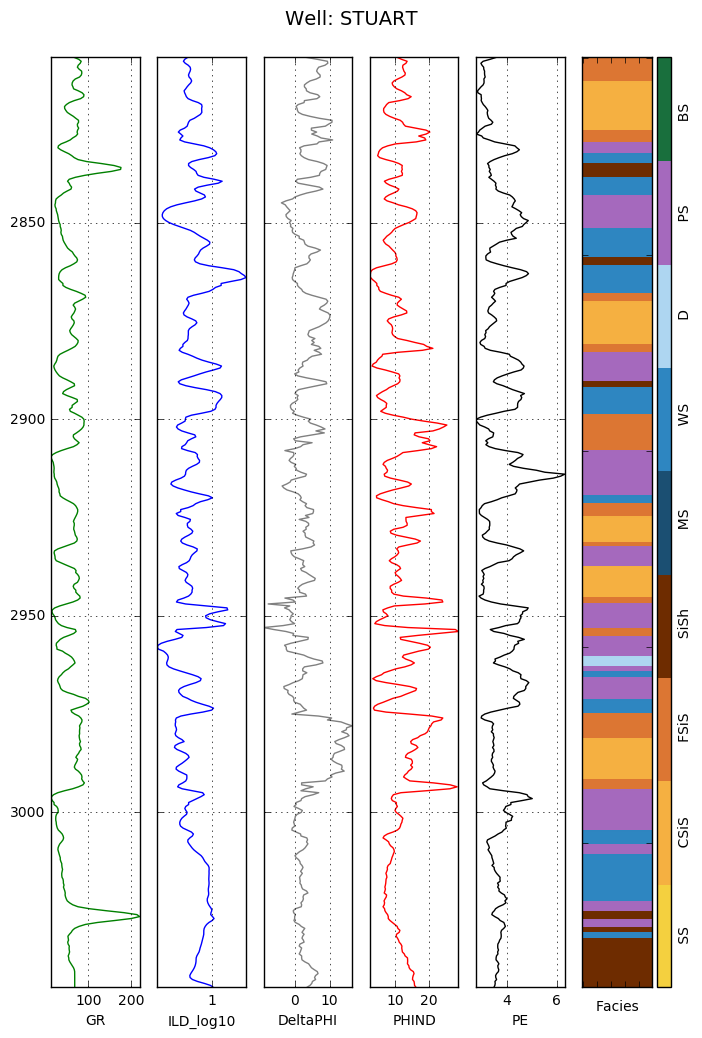

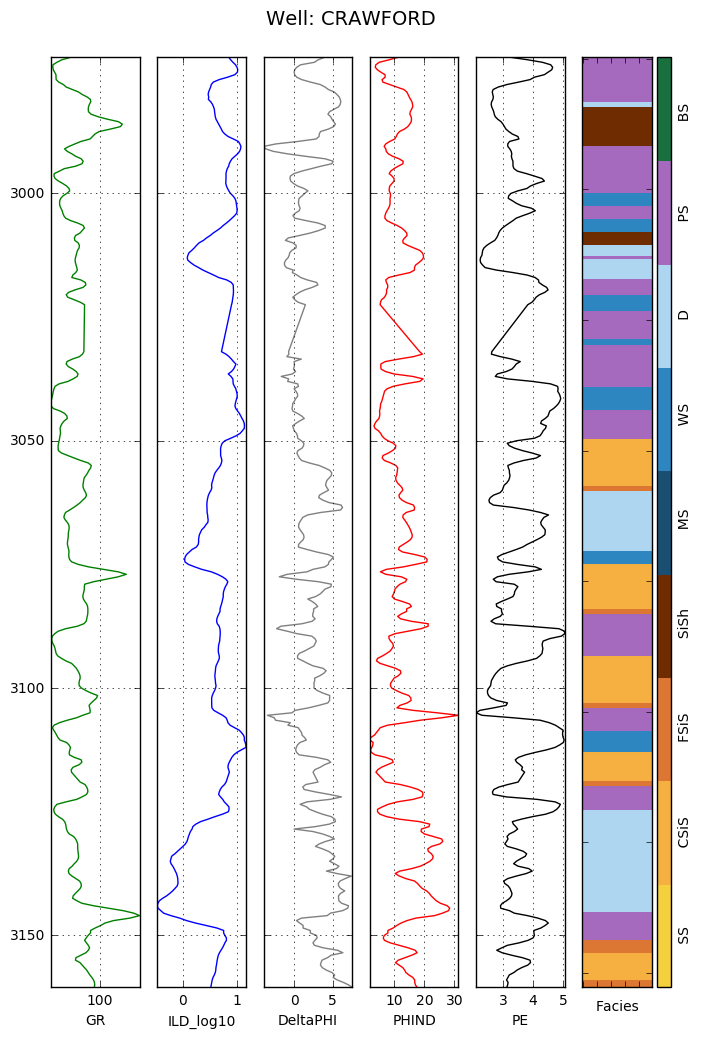

In [76]:
# Save predicted labels
np.save('04_ypred_XGB_SFS_VC_001.npy', y_pred)
blind.to_csv('04_ypred_XGB_SFS_VC_001.csv')

# Plot predicted labels
make_facies_log_plot(
    blind[blind['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    blind[blind['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)
mpl.rcParams.update(inline_rc)